In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### 1.1 Data Preparation

In [2]:
df=pd.read_csv('dataset/online_course_engagement_data.csv')

In [3]:
df.shape

(9000, 9)

In [4]:
df.describe()

,UserID,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4498.894556,50.163822,10.024667,5.090556,74.706028,50.340146,0.500667,0.396444
std,2596.849433,28.491750,6.029878,3.157762,14.378383,28.950977,0.500027,0.489186
min,1.000000,1.005230,0.000000,0.000000,50.005119,0.009327,0.000000,0.000000
25%,2251.750000,25.440548,5.000000,2.000000,62.283451,25.653614,0.000000,0.000000
50%,4483.500000,49.818417,10.000000,5.000000,74.743294,50.264124,1.000000,0.000000
75%,6751.250000,75.069924,15.000000,8.000000,87.022663,75.572493,1.000000,1.000000
max,9000.000000,99.992558,20.000000,10.000000,99.994984,99.979711,1.000000,1.000000


In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.head()

,userid,coursecategory,timespentoncourse,numberofvideoswatched,numberofquizzestaken,quizscores,completionrate,devicetype,coursecompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0


In [7]:
device={
    0:'desktop',
    1:'laptop'
}
df.devicetype = df.devicetype.map(device)

In [8]:
df.head()

,userid,coursecategory,timespentoncourse,numberofvideoswatched,numberofquizzestaken,quizscores,completionrate,devicetype,coursecompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,laptop,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,laptop,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,laptop,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,desktop,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,desktop,0


In [9]:
categorical = list(df.columns[df.dtypes=='object'])
for c in categorical:
    df[c] = df[c].str.lower()

In [10]:
df.dtypes

userid                     int64
coursecategory            object
timespentoncourse        float64
numberofvideoswatched      int64
numberofquizzestaken       int64
quizscores               float64
completionrate           float64
devicetype                object
coursecompletion           int64
dtype: object

In [11]:
numerical = ['timespentoncourse','numberofvideoswatched','numberofquizzestaken','quizscores','completionrate']

In [12]:
df.isnull().sum()

userid                   0
coursecategory           0
timespentoncourse        0
numberofvideoswatched    0
numberofquizzestaken     0
quizscores               0
completionrate           0
devicetype               0
coursecompletion         0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   userid                 9000 non-null   int64  
 1   coursecategory         9000 non-null   object 
 2   timespentoncourse      9000 non-null   float64
 3   numberofvideoswatched  9000 non-null   int64  
 4   numberofquizzestaken   9000 non-null   int64  
 5   quizscores             9000 non-null   float64
 6   completionrate         9000 non-null   float64
 7   devicetype             9000 non-null   object 
 8   coursecompletion       9000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 632.9+ KB


In [14]:
df.nunique()

userid                   8123
coursecategory              5
timespentoncourse        8123
numberofvideoswatched      21
numberofquizzestaken       11
quizscores               8123
completionrate           8123
devicetype                  2
coursecompletion            2
dtype: int64

### 1.2 Validation Framework

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df_full_train , df_test = train_test_split(df , test_size=0.2 , random_state=1)
df_train , df_val= train_test_split(df_full_train , test_size=0.25 ,random_state=1)

In [17]:
y_full_train = df_full_train.coursecompletion.values
y_train = df_train.coursecompletion.values
y_test = df_test.coursecompletion.values
y_val=df_val.coursecompletion.values

In [18]:
del df_train['coursecompletion']
del df_test['coursecompletion']
del df_val['coursecompletion']

In [19]:
df_full_train = df_full_train.reset_index(drop=True)
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)

### 1.3 EDA

In [20]:
round(df_full_train.coursecompletion.value_counts(normalize=True)*100,0)

coursecompletion
0    61.0
1    39.0
Name: proportion, dtype: float64

In [21]:
df_full_train.coursecompletion.mean()

0.39361111111111113

In [22]:
df_full_train[categorical].nunique()

coursecategory    5
devicetype        2
dtype: int64

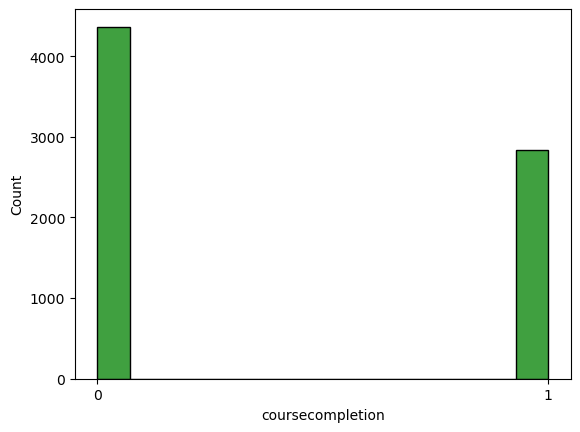

In [23]:
sns.histplot(data=df_full_train ,x=df_full_train.coursecompletion,color='green')
plt.xticks([0,1])
plt.show()

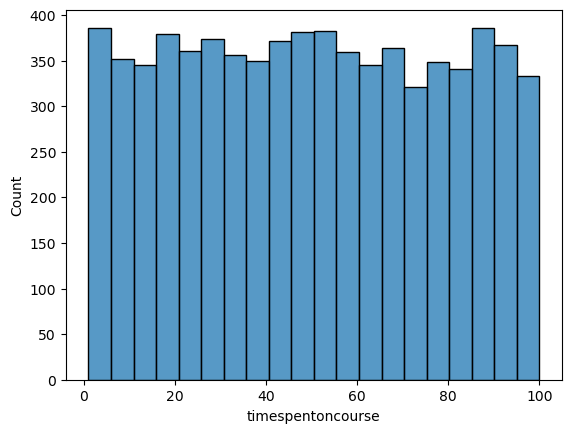

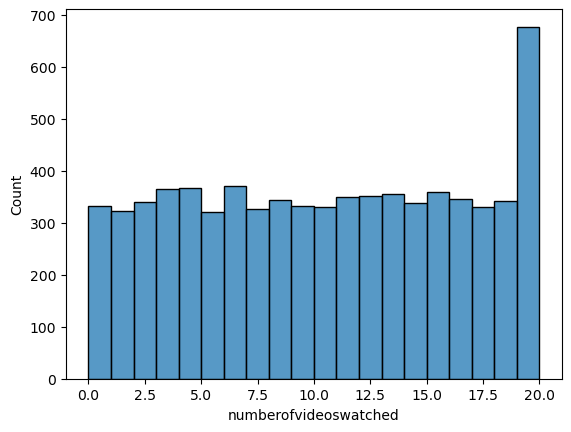

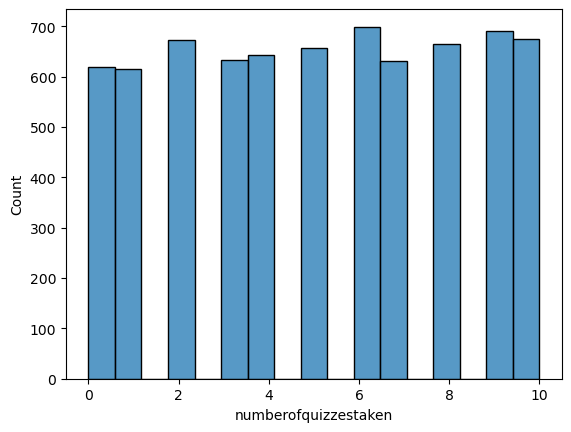

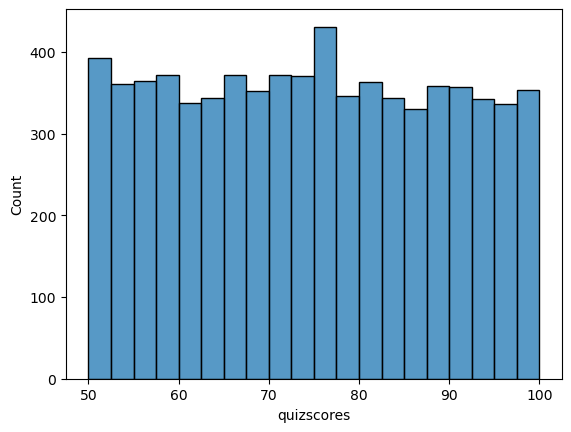

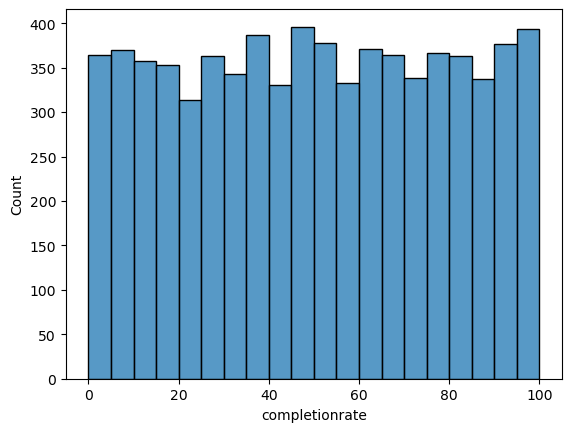

In [24]:
for n in numerical:
    sns.histplot(df_full_train,x=n)
    plt.show()

#### checking outliers

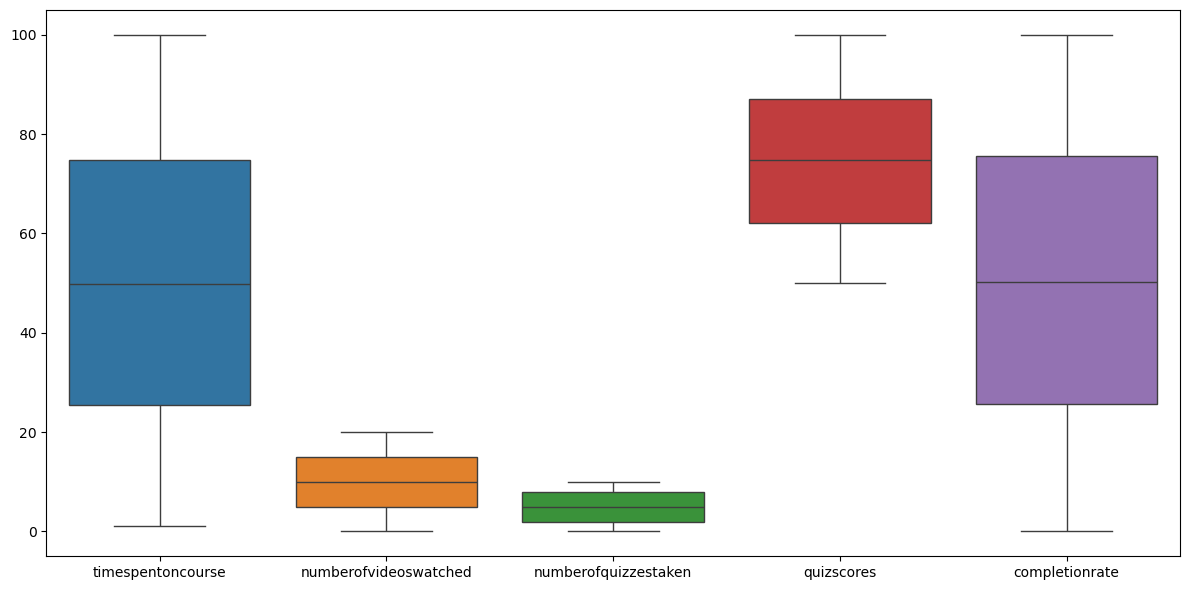

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_full_train[numerical])
plt.tight_layout()
plt.show()

#### Multicolinearity (when features are highly correlated with each other)

In [26]:
corr_matrix=df_full_train[numerical].corr()
corr_matrix

,timespentoncourse,numberofvideoswatched,numberofquizzestaken,quizscores,completionrate
timespentoncourse,1.000000,0.019453,-0.009788,0.003815,0.017626
numberofvideoswatched,0.019453,1.000000,-0.023955,-0.006998,0.021510
numberofquizzestaken,-0.009788,-0.023955,1.000000,-0.012291,0.006567
quizscores,0.003815,-0.006998,-0.012291,1.000000,-0.018379
completionrate,0.017626,0.021510,0.006567,-0.018379,1.000000


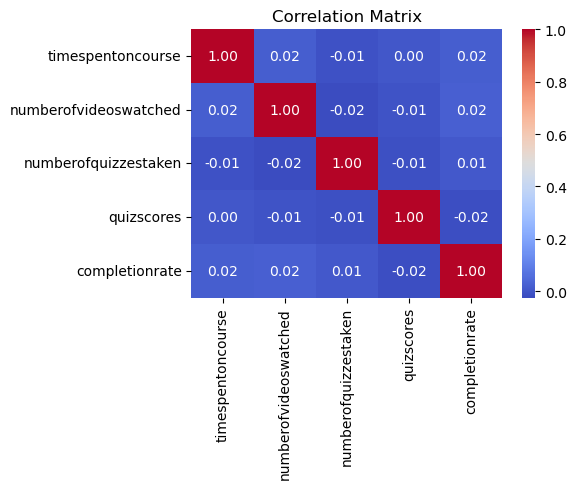

In [27]:
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### 1.4 Feature Importance analysis

In [28]:
from sklearn.metrics import mutual_info_score

In [29]:
def mutual_info_course_score(serial):
    return mutual_info_score(serial , df_full_train.coursecompletion)

mi = df_full_train[categorical+numerical].apply(mutual_info_course_score)
mi

/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


coursecategory           0.000225
devicetype               0.000031
timespentoncourse        0.670336
numberofvideoswatched    0.057119
numberofquizzestaken     0.065620
quizscores               0.670336
completionrate           0.670336
dtype: float64

In [30]:
mi_df=mi.sort_values().to_frame(name='mi_score')
mi_df

,mi_score
devicetype,0.000031
coursecategory,0.000225
numberofvideoswatched,0.057119
numberofquizzestaken,0.065620
quizscores,0.670336
timespentoncourse,0.670336
completionrate,0.670336


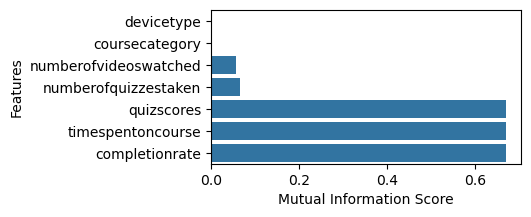

In [31]:
plt.figure(figsize=(4, 2))
sns.barplot(data=mi_df , x='mi_score',y=mi_df.index)
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

In [32]:
df_full_train[numerical].corrwith(df_full_train.coursecompletion)

timespentoncourse        0.193727
numberofvideoswatched    0.243961
numberofquizzestaken     0.279603
quizscores               0.302010
completionrate           0.326734
dtype: float64

### 1.5 Scaling Numerical Features

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [34]:
ss=StandardScaler()
X_train_num=ss.fit_transform(df_train[numerical])

X_train_num

array([[ 0.68460625,  0.33250297,  0.61570307, -0.99048501,  0.61766208],
       [ 0.76522372, -1.16473082,  0.61570307,  1.2925976 , -0.83581685],
       [ 1.20611478, -0.16657496,  1.24972226,  1.45694276,  0.02545957],
       ...,
       [-0.88456023, -1.49744944, -0.01831611, -0.04353891,  0.1403504 ],
       [-1.51851014, -1.33109013,  0.61570307, -0.28967269,  1.45627645],
       [-1.35453622, -1.49744944, -0.01831611,  0.90160241, -0.22720713]])

In [35]:
names_num=list(ss.get_feature_names_out())

In [36]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_cat = ohe.fit_transform(df_train[categorical].values)
X_train_cat

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [37]:
names_cat=list(ohe.get_feature_names_out(categorical))

In [38]:
X_train = np.column_stack([X_train_cat,X_train_num])

### 1.6 LogisticRegression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
lr.fit(X_train , y_train)

LogisticRegression(random_state=42)

In [40]:
lr.intercept_

array([-0.44857107])

In [41]:
coef=lr.coef_[0]

In [42]:
y_pred_train=lr.predict(X_train)
auc=roc_auc_score(y_pred_train,y_train)
print('train' , auc)

train 0.797745455775392


In [43]:
X_val_cat = ohe.transform(df_val[categorical].values)
X_val_num=ss.transform(df_val[numerical])

X_val=np.column_stack([X_val_cat,X_val_num])

In [44]:
y_pred = lr.predict(X_val)

In [45]:
auc=roc_auc_score(y_pred , y_val)
print('val' , auc)

val 0.7906563215910111


### 1.7 Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [47]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train , y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val,y_pred)

    print('%4s->%.3f' % (d,auc))

   1->0.673
   2->0.777
   3->0.862
   4->0.929
   5->0.951
   6->0.950
  10->0.938
  15->0.930
  20->0.921
None->0.922


In [48]:
scores=[]

for d in [4,5,6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d , min_samples_leaf=s)
        dt.fit(X_train , y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val,y_pred)

        scores.append((d,s,auc))

c = ['max_depth' , 'min_samples_leaf','auc']
scores_df=pd.DataFrame(scores , columns=c)
scores_df.sort_values(by='auc',ascending=False)

,max_depth,min_samples_leaf,auc
15,5,100,0.956370
24,6,100,0.954780
19,6,2,0.953021
14,5,20,0.952380
23,6,20,0.952345
22,6,15,0.951922
13,5,15,0.951880
12,5,10,0.951586
21,6,10,0.951176
20,6,5,0.951111


In [49]:
scores_df_pivot=scores_df.pivot(index='min_samples_leaf',columns=['max_depth'],values='auc')
scores_df_pivot

max_depth,4,5,6
min_samples_leaf,,,
1,0.929430,0.950783,0.949215
2,0.929430,0.950721,0.953021
5,0.929662,0.950804,0.951111
10,0.929567,0.951586,0.951176
15,0.929567,0.951880,0.951922
20,0.929540,0.952380,0.952345
100,0.929652,0.956370,0.954780
200,0.918505,0.940920,0.941801
500,0.879015,0.879015,0.879015


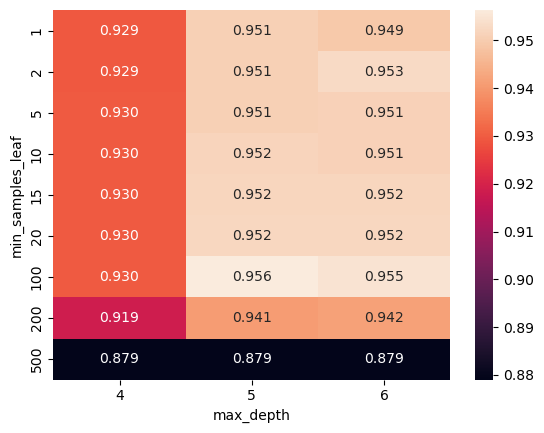

In [50]:
sns.heatmap(scores_df_pivot,annot=True,fmt=('.3f'))
plt.show()

In [51]:
#comapre train and validation frames
dt = DecisionTreeClassifier(max_depth=5 , min_samples_leaf=100)
dt.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

In [52]:
names = names_cat + names_num
names

['coursecategory_arts',
 'coursecategory_business',
 'coursecategory_health',
 'coursecategory_programming',
 'coursecategory_science',
 'devicetype_desktop',
 'devicetype_laptop',
 'timespentoncourse',
 'numberofvideoswatched',
 'numberofquizzestaken',
 'quizscores',
 'completionrate']

In [53]:
print(export_text(dt,feature_names=names))

|--- completionrate <= 0.33
|   |--- quizscores <= -0.33
|   |   |--- quizscores <= -1.60
|   |   |   |--- class: 0
|   |   |--- quizscores >  -1.60
|   |   |   |--- quizscores <= -1.48
|   |   |   |   |--- class: 0
|   |   |   |--- quizscores >  -1.48
|   |   |   |   |--- timespentoncourse <= -1.01
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- timespentoncourse >  -1.01
|   |   |   |   |   |--- class: 0
|   |--- quizscores >  -0.33
|   |   |--- numberofquizzestaken <= -0.49
|   |   |   |--- completionrate <= -0.22
|   |   |   |   |--- quizscores <= 0.38
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- quizscores >  0.38
|   |   |   |   |   |--- class: 0
|   |   |   |--- completionrate >  -0.22
|   |   |   |   |--- class: 0
|   |   |--- numberofquizzestaken >  -0.49
|   |   |   |--- numberofvideoswatched <= -0.75
|   |   |   |   |--- timespentoncourse <= -0.12
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- timespentoncourse >  -0.12
|   |   |   |   |   |--- class

In [54]:
y_pred=dt.predict(X_train)
auc_train=roc_auc_score(y_pred,y_train)
auc_train

0.9317531930435157

### 1.8 Random forest

In [55]:
X_test_cat = ohe.transform(df_test[categorical].values)
X_test_num=ss.transform(df_test[numerical])

X_test=np.column_stack([X_test_cat,X_test_num])

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rf = RandomForestClassifier(n_estimators=5,random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=5, random_state=42)

In [58]:
y_pred_train=rf.predict(X_train)
auc=roc_auc_score(y_pred,y_train)
print('train_auc',auc)

train_auc 0.9317531930435157


In [67]:
y_pred_val=rf.predict(X_val)
auc=roc_auc_score(y_pred_val,y_val)
print('val_auc',auc)

val_auc 0.9618067174167642


In [60]:
# determin best n_estimators e.g numbe of trees
scores=[]

for n in range(1,50,1):
    rf = RandomForestClassifier(n_estimators=n,random_state=42)
    rf.fit(X_train,y_train)

    y_pred=rf.predict(X_val)
    auc=roc_auc_score(y_pred,y_val)
    scores.append((n,auc))
scores_df=pd.DataFrame(scores , columns=['n_estimators_nbr_trees','auc'])

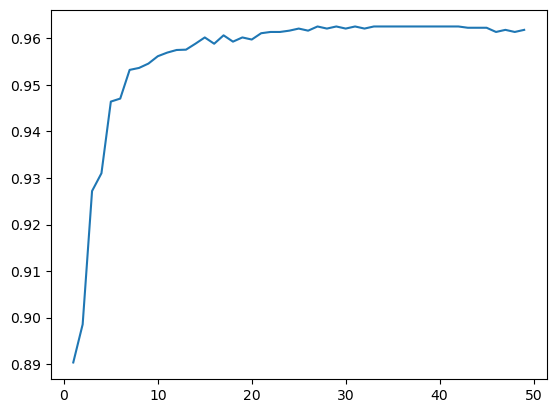

In [61]:
plt.plot(scores_df.n_estimators_nbr_trees,scores_df.auc)
plt.show()

In [62]:
best_n_estimator = 20

In [71]:
#determin best max_depth
scores=[]
for d in [2,6,10]:
    for n in range(1,51,1):
        rfmodel=RandomForestClassifier(n_estimators= n , max_depth=d, random_state=42)
        rfmodel.fit(X_train,y_train)

        y_pred=rfmodel.predict(X_val)
        auc=roc_auc_score(y_pred,y_val)
        scores.append((d,n,auc))

scores_df=pd.DataFrame(scores , columns=['max_depth','n_estimators_nbr_trees','auc'])
scores_df.sort_values(by='auc',ascending=False).head()


,max_depth,n_estimators_nbr_trees,auc
135,10,36,0.959837
139,10,40,0.959837
98,6,49,0.959837
99,6,50,0.959837
123,10,24,0.959837


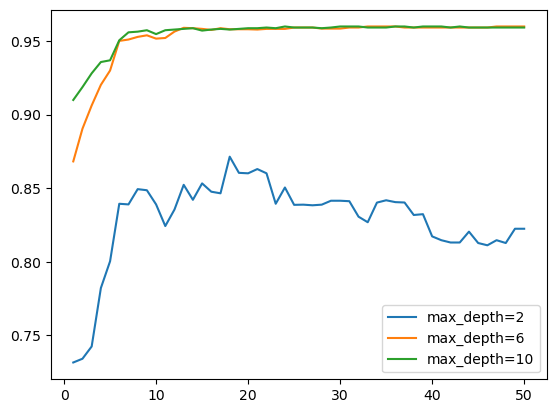

In [64]:
for d in [2,6,10]:
    df_subset=scores_df[scores_df.max_depth==d]

    plt.plot(df_subset.n_estimators_nbr_trees,df_subset.auc , label='max_depth=%d'%d)
plt.legend()
plt.show()

In [104]:
best_max_depth = 10

In [107]:
# determin best min_samples_leaf
scores = []
 
for s in [1, 3, 5, 10, 50]:
    for n in range(1, 51, 1):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=best_max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
 
        y_pred = rf.predict_proba(X_val)[:, 1] 
        auc = roc_auc_score(y_val, y_pred)
 
        scores.append((s, n, auc))
 
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [108]:
df_scores.sort_values(by='auc',ascending=False).head()

,min_samples_leaf,n_estimators,auc
58,3,9,0.958040
57,3,8,0.957840
56,3,7,0.957082
55,3,6,0.956935
9,1,10,0.956512


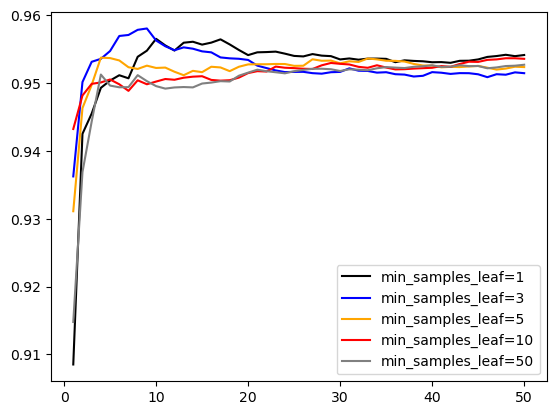

In [113]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
 
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf== s]
     
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
 
plt.legend()
plt.show()

In [114]:
rfmodel=RandomForestClassifier(max_depth=best_max_depth , n_estimators=30 , min_samples_leaf=10 , random_state=42)
rfmodel.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=30,
                       random_state=42)

In [115]:
y_pred=rfmodel.predict(X_val)
auc=roc_auc_score(y_pred,y_val)
print('val_auc',auc)

val_auc 0.960552094698436


### 1.9 XGBoost

In [121]:
dtrain=xgb.DMatrix(X_train,label=y_train,feature_names=names)
dval=xgb.DMatrix(X_val,label=y_val,feature_names=names)

In [134]:
%%capture output

xgb_params = {
    'eta' : 0.3 ,
    'max_depth' : 6,
    'min_child_weight': 1,

    'objective' : 'binary:logistic',
    'nthreads': 8,
    'eval_metric' : 'auc',

    'seed': 42,
    'verbosity': 1
}

watchlist = [(dtrain,'train'),(dval,'validation')]

model=xgb.train(xgb_params,dtrain,num_boost_round=200,verbose_eval=5,evals=watchlist)

In [148]:
def parse_output(output):
    results = []
 
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
 
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
 
        results.append((it, train, val))
     
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [149]:
df_score = parse_output(output)
df_score

,num_iter,train_auc,val_auc
0,0,0.96630,0.95252
1,5,0.98502,0.95213
2,10,0.99159,0.95560
3,15,0.99453,0.95468
4,20,0.99610,0.95492
5,25,0.99693,0.95535
6,30,0.99761,0.95462
7,35,0.99830,0.95547
8,40,0.99852,0.95625
9,45,0.99870,0.95701


In [135]:
y_pred=model.predict(dval)
auc=roc_auc_score(y_val,y_pred)
auc

0.9578066512545116

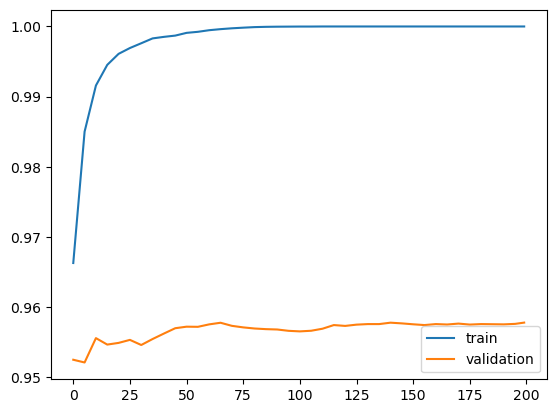

In [151]:
plt.plot(df_score.num_iter , df_score.train_auc, label='train')
plt.plot(df_score.num_iter , df_score.val_auc, label='validation')
plt.legend()
plt.show()

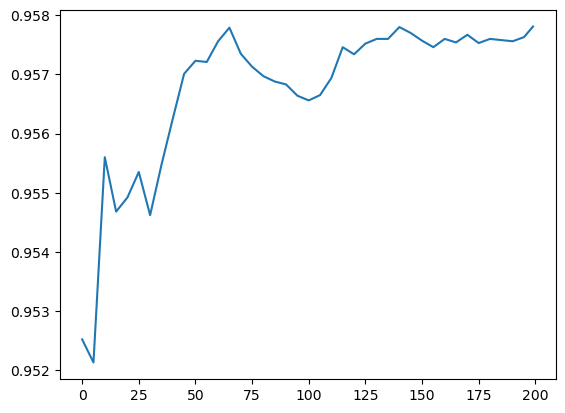

In [153]:
plt.plot(df_score.num_iter , df_score.val_auc , label='validation')
plt.show()

### GridSearhc

In [161]:
from sklearn.model_selection import GridSearchCV

In [165]:
%%capture output
 
params = {
    'eta': [0.01,0.05,0.1,0.3], 
    'max_depth': [3,6,4,10],
    'min_child_weight': [1,3,5,7,9,11]
}
 
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    nthread=8,
    seed=1
)

In [166]:
gridsearch=GridSearchCV(estimator=xgb_model,param_grid=params,scoring='roc_auc',cv=5,verbose=1,n_jobs=-1)

gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kazeka/anaconda3/envs/ml-zoomc

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=8,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [3, 6, 4, 10],
                         'min_child_weight': [1, 3, 5, 7, 9, 11]},
             scoring='roc_auc', verbose=1)

In [167]:
gridsearch.best_params_

{'eta': 0.1, 'max_depth': 10, 'min_child_weight': 3}

In [168]:
gridsearch.best_score_

0.9665479954250433